In [16]:
import keras 
import tensorflow as tf
from keras.layers import Conv2D , Conv2DTranspose , Input , Flatten , Dense , Lambda, Reshape
import keras.layers
from keras.models import Model 
from keras.datasets import mnist
from keras import backend as k 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import animation
import numpy as np
from ipywidgets import interact, FloatSlider

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


MNIST Images Shape : (28, 28)


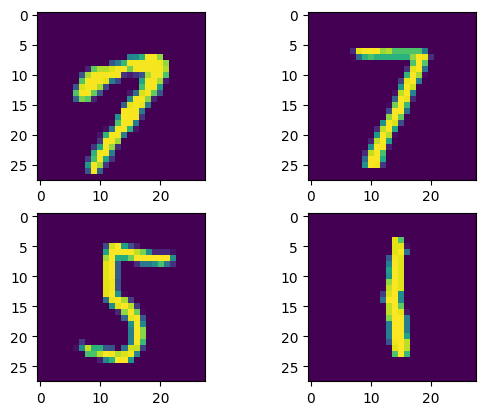

In [17]:
(x_train , y_train) , (x_test , y_test) = mnist.load_data()

### Data Normalization 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255
x_test = x_test / 255

### Reshaping Images 
img_width = x_train.shape[1]
img_height = x_train.shape[2]

print(f"MNIST Images Shape : {img_width , img_height }")

num_channels = 1 ### MNIST dataset ==> grey scale images ==> 1 channel 
x_train = x_train.reshape(x_train.shape[0] , img_height , img_width, num_channels) 
x_test = x_test.reshape(x_test.shape[0] , img_height , img_width , num_channels) 

input_shape = (img_height , img_width , num_channels)



### Visualizing the Data 

plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[15][:,:,0])

plt.subplot(222)
plt.imshow(x_train[560][:,:,0])

plt.subplot(223)
plt.imshow(x_train[3500][:,:,0])

plt.subplot(224)
plt.imshow(x_train[35000][:,:,0])
plt.show()

In [18]:
#@@@@@@@@@@@@@@@@@@@@@
#@@@@@@ Encoder @@@@@@
#@@@@@@@@@@@@@@@@@@@@@

latent_dim= 3


input_img = Input(shape=input_shape , name="enc_input")
x = Conv2D(32 , 3 , padding="same" , activation="relu")(input_img)
x = Conv2D(64 , 3 , padding="same" , activation="relu" , strides=(2,2))(x)
x = Conv2D(64 , 3 , padding="same" , activation="relu")(x)
x = Conv2D(64 , 3 , padding="same" , activation="relu")(x)
x = Conv2D(64 , 3 , padding="same" , activation="relu")(x)

conv_shape = k.int_shape(x) ### Shape to be provided to the decoder
print(f"Shape to be provided to the decoder : {conv_shape}")
x = Flatten()(x)
x = Dense(32,activation='relu')(x)

### 
z_mu = Dense(latent_dim , name="latent_mu")(x) ### Mean value of encoded input
z_sigma = Dense(latent_dim , name="latent_sigma")(x) ### Standard deviation of encoded input

### Reparameterization Trick : 

def sample_z(args):
    z_mu , z_sigma = args
    eps = k.random_normal(shape=(k.shape(z_mu)[0],k.int_shape(z_mu)[1]))
    return z_mu + k.exp(z_sigma/2)*eps

z = Lambda(sample_z , output_shape=(latent_dim, ) , name='z')([z_mu,z_sigma])

encoder = Model(input_img , [z_mu,z_sigma,z] , name="encoder")
print(encoder.summary())


Shape to be provided to the decoder : (None, 14, 14, 64)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         enc_input[0][0]                  
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_5[0][0]                   
___________________________________

In [19]:
#@@@@@@@@@@@@@@@@@@@@@
#@@@@@@ Decoder @@@@@@
#@@@@@@@@@@@@@@@@@@@@@

### the decoder takes the latent vector z as input
decoder_input = Input(shape=(latent_dim,) , name="dec_input")
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3] , activation="relu")(decoder_input) ## decoder will receive the output of the flattening layer 
x = Reshape((conv_shape[1] , conv_shape[2] , conv_shape[3]))(x)
x = Conv2DTranspose(32,3,padding='same' , activation="relu" , strides=(2,2))(x)
x = Conv2DTranspose(num_channels , 3 , padding='same' , activation='relu' , name="decoder_deconv")(x)


decoder = Model(decoder_input , x , name="decoder")
print(decoder.summary())

z_decoded = decoder(z) ### Reconstructed Image 
print("shape of the decoded Image : " , z_decoded.shape) ### Same shape as the input image 

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_input (InputLayer)       [(None, 3)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             50176     
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_deconv (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 68,929
Trainable params: 68,929
Non-trainable params: 0
_________________________________________________________________
None
shape of the decoded Image :  (None, 28, 28, 1)


In [6]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
#@@@@@@ Building the Model @@@@@@
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

class VAE(keras.Model) : 
    def __init__(self,encoder,decoder,beta,**kwargs):
        super(VAE,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta 
        
    def compile(self , optimizer) : 
        super(VAE,self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker =  tf.keras.metrics.Mean(name="Loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="Recon_Loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="KL_Loss")
        
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker ,
            self.kl_loss_tracker
            ]
    
    def train_step(self , data) : 
        
        if isinstance(data,tuple) : 
            data = data[0]
        
        with tf.GradientTape() as tape : 
            z_mean , z_sigma , z = self.encoder(data)
            recon = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, recon) , axis=(1,2)))
            kl_loss = -0.5*tf.reduce_mean(tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z_sigma),axis=1))
            total_loss = recon_loss + self.beta*kl_loss
            
        grads = tape.gradient(total_loss , self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
    
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
    def call(self, inputs):
        """Required for model.__call__ and validation to work."""
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

Epoch 1/15
Train Loss: 3.5177, Validation Loss: 2.6592
Epoch 2/15
Train Loss: 2.8608, Validation Loss: 2.4408
Epoch 3/15
Train Loss: 2.7182, Validation Loss: 2.4032
Epoch 4/15
Train Loss: 2.6515, Validation Loss: 2.3912
Epoch 5/15
Train Loss: 2.6001, Validation Loss: 2.3532
Epoch 6/15
Train Loss: 2.5583, Validation Loss: 2.3336
Epoch 7/15
Train Loss: 2.5304, Validation Loss: 2.3279
Epoch 8/15
Train Loss: 2.5087, Validation Loss: 2.4005
Epoch 9/15
Train Loss: 2.4968, Validation Loss: 2.3179
Epoch 10/15
Train Loss: 2.4866, Validation Loss: 2.3074
Epoch 11/15
Train Loss: 2.4723, Validation Loss: 2.4968
Epoch 12/15
Train Loss: 2.4606, Validation Loss: 2.5265
Epoch 13/15
Train Loss: 2.4499, Validation Loss: 2.2706
Epoch 14/15
Train Loss: 2.4376, Validation Loss: 2.2593
Epoch 15/15
Train Loss: 2.4258, Validation Loss: 2.2254


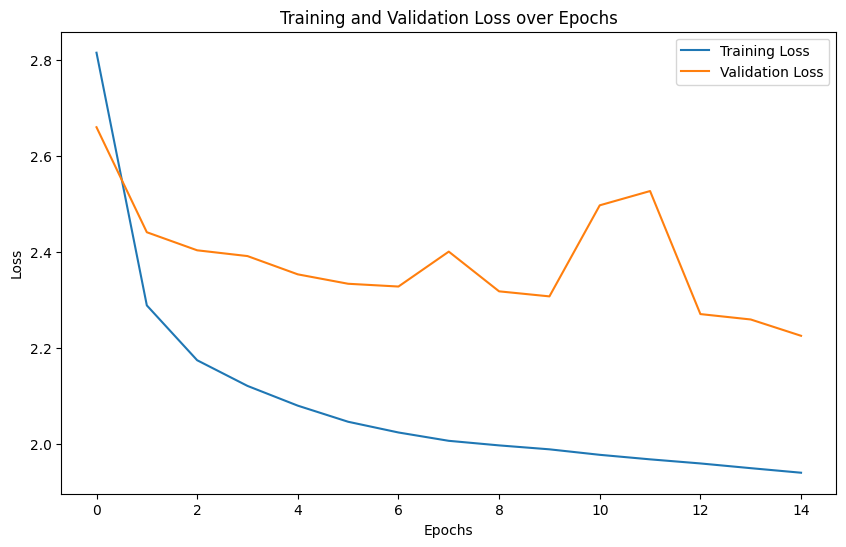

In [20]:
# Instantiate the VAE model
vae = VAE(encoder, decoder, beta=0.5)
vae.compile(tf.keras.optimizers.Adam())

history = {'loss': [], 'val_loss': []}

from sklearn.model_selection import train_test_split

# Assuming x_train is your original dataset
x_train_split, x_val_split = train_test_split(x_train, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices(x_train_split)
train_validation = tf.data.Dataset.from_tensor_slices(x_val_split)
# Training loop with validation loss tracking
epochs = 15
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    
    # Train step
    train_loss = 0.0
    for batch_data in train_dataset.batch(64):  # Assuming x_train is a tf.data.Dataset or numpy array
        with tf.device('/GPU:0'):
            logs = vae.train_step(batch_data)
        train_loss += logs['loss'].numpy()

    # Record training loss
    history['loss'].append(train_loss / len(x_train))

    # Validation loss calculation
    val_loss = 0.0
    for batch_data in train_validation.batch(64):  # Assuming x_val is your validation data
        with tf.device('/GPU:0'):
            val_output = vae(batch_data)
        z_mean, z_sigma, z = vae.encoder(batch_data)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(batch_data, val_output), axis=(1,2)))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z_sigma), axis=1))
        val_loss += recon_loss + vae.beta * kl_loss

    # Record validation loss
    history['val_loss'].append(val_loss / len(train_validation))

    print(f'Train Loss: {train_loss / len(train_dataset):.4f}, Validation Loss: {val_loss / len(train_validation):.4f}')

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
vae.summary() 

Model: "vae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         [(None, 3), (None, 3), (N 531238    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         68929     
Total params: 600,173
Trainable params: 600,167
Non-trainable params: 6
_________________________________________________________________


In [22]:
mu,_,_ = encoder.predict(x_test)

In [23]:

import plotly.express as px
import pandas as pd

df = pd.DataFrame(mu, columns=["dim1", "dim2", "dim3"])
df["label"] = y_test

fig = px.scatter_3d(df, x="dim1", y="dim2", z="dim3",
                    color=df["label"].astype(str), 
                    color_continuous_scale="brbg")

fig.update_traces(marker=dict(size=3))
fig.update_layout(title="Latent Space (3D)", margin=dict(l=0, r=0, b=0, t=30))
fig.show()

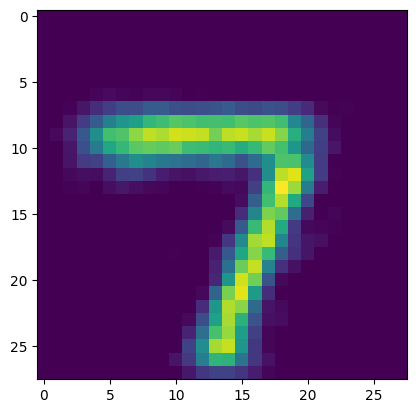

In [27]:
sample_vector = np.array([[2.26,-1.16,-0.09]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaepd = decoded_example.reshape(img_width , img_height)
plt.imshow(decoded_example_reshaepd)

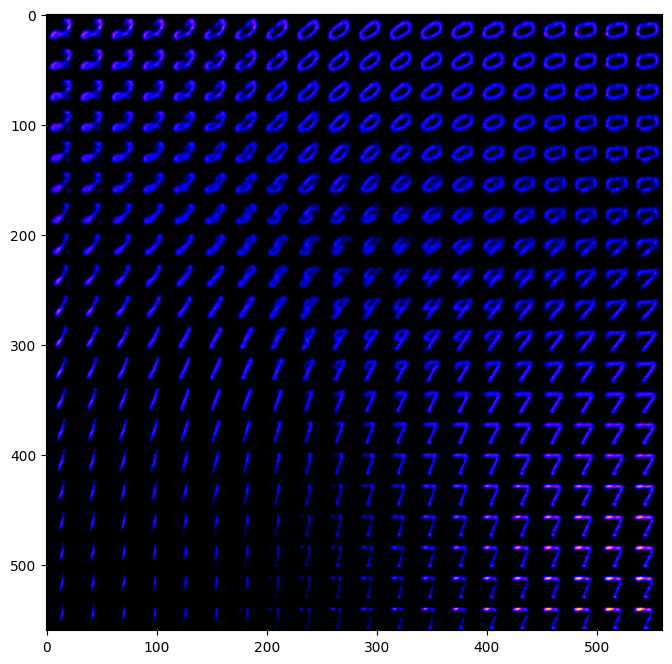

In [28]:
###########################
# For a fixed value of dim3 
###########################
n = 20 
figure = np.zeros((img_width * n , img_height*n , num_channels))
grid_x = np.linspace(-3,3,n)
grid_y = np.linspace(-3,3,n)[::-1]
fixed_z3 = -1
for i , j in enumerate(grid_y) : 
    for k , l in enumerate(grid_x) : 
        z_sample = np.array([[l,j,fixed_z3]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width , img_height , num_channels)
        figure[i*img_width : (i+1) * img_width,
               k*img_height : (k+1) * img_height] = digit
        
plt.figure(figsize=(8,8))
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0] , fig_shape[1]))
plt.imshow(figure , cmap="gnuplot2") 
plt.show()

In [29]:
##############################
# For any chosen value of dim3 
##############################

def plot_latent_slice(z3):
    n = 20
    figure = np.zeros((img_width * n, img_height * n, num_channels))
    grid_x = np.linspace(-5, 5, n)
    grid_y = np.linspace(-5, 5, n)[::-1]

    for i, y in enumerate(grid_y):
        for j, x in enumerate(grid_x):
            z_sample = np.array([[x, y, z3]])
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                   j * img_height: (j + 1) * img_height] = digit

    plt.figure(figsize=(8, 8))
    if num_channels == 1:
        plt.imshow(figure.squeeze(), cmap   ='gray')
    else:
        plt.imshow(figure) #kasra f ydayk zawz ba33ed 3liya     aslan lfaza heki 9bal dharbet trend maa prianka w jones
    plt.title(f"Latent Dimension 3 = {z3:.2f}")
    plt.axis("off")
    plt.show()

interact(plot_latent_slice, z3=FloatSlider(min=-3.0, max=3.0, step=0.2, value=0.0));


interactive(children=(FloatSlider(value=0.0, description='z3', max=3.0, min=-3.0, step=0.2), Output()), _dom_c…